In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

MONTH = 21
YEAR = 12 * MONTH

START = '2013-01-01'
END = '2017-12-31'

sns.set_style('whitegrid')
idx = pd.IndexSlice



In [2]:
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

DATA_STORE = './data/assets.h5'

with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel()
              .sort_index())

    stocks = (store['us_equities/stocks']
              .loc[:, ['marketcap', 'ipoyear', 'sector']])



In [3]:
# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level='ticker').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]

In [4]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

shared = (prices.index.get_level_values('ticker').unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

prices.info(show_counts=True)



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2904233 non-null  float64
 1   close   2904233 non-null  float64
 2   low     2904233 non-null  float64
 3   high    2904233 non-null  float64
 4   volume  2904233 non-null  float64
dtypes: float64(5)
memory usage: 122.6+ MB


In [5]:
stocks.info(show_counts=True)



<class 'pandas.core.frame.DataFrame'>
Index: 2348 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2345 non-null   float64
 1   ipoyear    1026 non-null   float64
 2   sector     2348 non-null   object 
dtypes: float64(2), object(1)
memory usage: 73.4+ KB


In [6]:
stocks.sector.value_counts()

sector
consumer_services        440
finance                  393
technology               297
health_care              297
capital_goods            227
basic_industries         138
consumer_non-durables    126
energy                   123
public_utilities         105
consumer_durables         78
miscellaneous             69
transportation            55
Name: count, dtype: int64

In [7]:


# compute dollar volume to determine universe
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)

# Reset index to ensure compatibility
prices_reset = prices.reset_index()

# Compute the rolling mean
rolling_means = (prices_reset.groupby('ticker')['dollar_vol']
                 .rolling(window=21)
                 .mean()
                 .reset_index(drop=True))


# Assign the result back to the original DataFrame
prices['dollar_vol_1m'] = rolling_means

prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           2904233 non-null  float64
 1   close          2904233 non-null  float64
 2   low            2904233 non-null  float64
 3   high           2904233 non-null  float64
 4   volume         2904233 non-null  float64
 5   dollar_vol     2904233 non-null  float64
 6   dollar_vol_1m  0 non-null        float64
dtypes: float64(7)
memory usage: 166.9+ MB


In [8]:
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

prices.info(show_counts=True)



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2904233 non-null  float64
 1   close            2904233 non-null  float64
 2   low              2904233 non-null  float64
 3   high             2904233 non-null  float64
 4   volume           2904233 non-null  float64
 5   dollar_vol       2904233 non-null  float64
 6   dollar_vol_1m    0 non-null        float64
 7   dollar_vol_rank  0 non-null        float64
dtypes: float64(8)
memory usage: 189.1+ MB


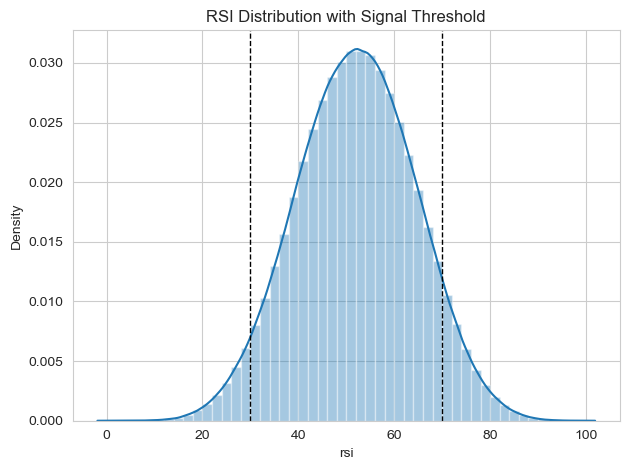

In [9]:
# Assuming the RSI function is defined correctly and can handle series input
prices['rsi'] = prices.groupby(level='ticker')['close'].transform(RSI)

# Plotting
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')  # Lower RSI threshold
ax.axvline(70, ls='--', lw=1, c='k')  # Upper RSI threshold
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout()




In [10]:
prices = prices.join(stocks[['sector']])

In [12]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

prices.info()



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   open             float64
 1   close            float64
 2   low              float64
 3   high             float64
 4   volume           float64
 5   dollar_vol       float64
 6   dollar_vol_1m    float64
 7   dollar_vol_rank  float64
 8   rsi              float64
 9   sector           object 
 10  year             int32  
 11  month            int32  
dtypes: float64(9), int32(2), object(1)
memory usage: 255.6+ MB


In [13]:


prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('data.h5', 'model_data/no_dummies')

prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

prices.info()



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 35 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   open                   float64
 1   close                  float64
 2   low                    float64
 3   high                   float64
 4   volume                 float64
 5   dollar_vol             float64
 6   dollar_vol_1m          float64
 7   dollar_vol_rank        float64
 8   rsi                    float64
 9   year_2014              bool   
 10  year_2015              bool   
 11  year_2016              bool   
 12  year_2017              bool   
 13  month_2                bool   
 14  month_3                bool   
 15  month_4                bool   
 16  month_5                bool   
 17  month_6                bool   
 18  month_7                bool   
 19  month_8                bool   
 20  month_9          

In [18]:
lags = [1, 5, 10, 21, 42, 63]

returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

q = 0.0001

# Winsorize outliers

for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

# Shift lagged returns

for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

# Compute Forward Returns

for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

prices.to_hdf('data.h5', 'model_data')

target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()



In [19]:


top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

top100.groupby('rsi_signal')['target_5d'].describe()



,count,mean,std,min,25%,50%,75%,max
